In [ ]:
#Read data from dbf

In [1]:
import pandas as pd

dbf5_crash = Dbf5('massdot_crashes_12_14_MA.dbf',codec='utf-8')
dbf5_roads = Dbf5('boston_road_massdot2015_MA.dbf',codec='utf-8')
dbf5_crash.to_csv('massdot_crashes_12_14_MA.csv')
dbf5_roads.to_csv('boston_road_massdot2015_MA.csv')

In [7]:
#clean the massdot crash data file to make single crash record for each crash
incident_data = pd.read_csv('massdot_crashes_12_14_MA.csv')
incident_data.columns = incident_data.columns.str.lower()
print len(incident_data.index)
incident_data.drop_duplicates(inplace=True)
print len(incident_data.index)

incident_data.drop('vehicle_number',axis=1,inplace=True)
incident_data.drop('vehicle_configuration',axis=1,inplace=True)
incident_data.drop('vehicle_travel_directions',axis=1,inplace=True)
incident_data.drop('vehicle_action_prior_to_crash',axis=1,inplace=True)

#Each incident is reported as multiple crashes. If one crash involves 2 vehicles , 2 crash reports are filed
#Making each incident has one entry
incident_data.drop_duplicates('crash_number',inplace=True)
print len(incident_data.index)

#convert date to two new columns 'year' and 'day'
from datetime import datetime
date_to_dayofweek_converter = lambda x: datetime.strptime(str(x), '%m/%d/%y').strftime('%a')
date_to_year_converter = lambda x: datetime.strptime(str(x), '%m/%d/%y').strftime('%y')

def time_to_hour_converter(x):
    if x == '0S':
        return -1
    else:
        return datetime.strptime(str(x), '%HH %MM %SS').strftime('%H')

incident_data['day'] = incident_data['crash_date'].apply(date_to_dayofweek_converter)
incident_data['year'] = incident_data['crash_date'].apply(date_to_year_converter)
incident_data['hour'] = incident_data['crash_time'].apply(time_to_hour_converter)

incident_data.to_csv('massdot_crashes_12_14_MA_unique.csv')

22790
22787
11924


In [8]:
# read from csv to create a dataframe and convert column names to lowercase
import pandas as pd
pd.set_option('display.max_colwidth', -1)
crash_data = pd.read_csv('massdot_crashes_12_14_MA_unique.csv')
road_data = pd.read_csv('boston_road_massdot2015_MA.csv')
crash_data.columns = crash_data.columns.str.lower()
road_data.columns = road_data.columns.str.lower()

In [9]:
# Join crash_data and road_data on near_fid and strsegfid
crash_road_data = crash_data.merge(road_data, left_on='near_fid', right_on='strsegfid', how='left')
# remove rows with fid = -1
crash_road_data = crash_road_data[crash_road_data.near_fid_x != -1]

#drop zero information columms or duplicates
crash_road_data.drop('city_town_name',axis=1, inplace='True')
crash_road_data.drop('city_x',axis=1, inplace='True')
crash_road_data.drop('city_y',axis=1, inplace='True')
crash_road_data.drop('date_time',axis=1, inplace='True')
crash_road_data.drop('near_fid_y',axis=1, inplace='True')
crash_road_data.drop('strsegfid',axis=1, inplace='True')
crash_road_data.drop('mpo',axis=1, inplace='True')

crash_road_data.to_csv('crash_road_12_14_MA_unique.csv')

11561
14622
2932


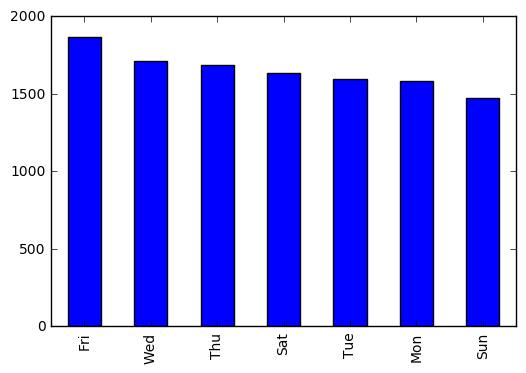

In [10]:
#basic analysis
%matplotlib inline
import matplotlib
#Total accident reports from 2012 to 2014 with valid FID data : 22,135 
print len(crash_road_data.index)

#Total number of street segments in boston : 14,622
print len(road_data.index)

#Number of street segments that has see a crash : 2,932
print len(crash_road_data.near_fid_x.unique())

#number of crashes every weekday
crash_road_data.day.value_counts().plot(kind='bar')

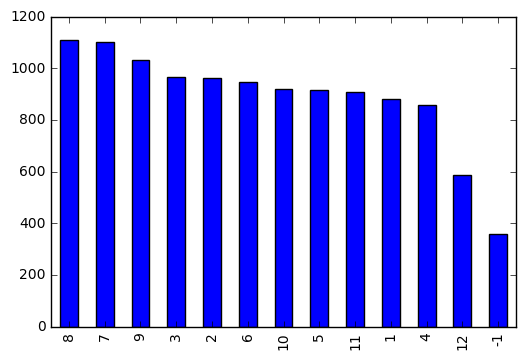

In [12]:
#number of crashes vs hour of day (-1 where the data has no time entry)
# not sure only 12 hours, there was not AM PM details in the data
crash_road_data.hour.value_counts().plot(kind='bar')

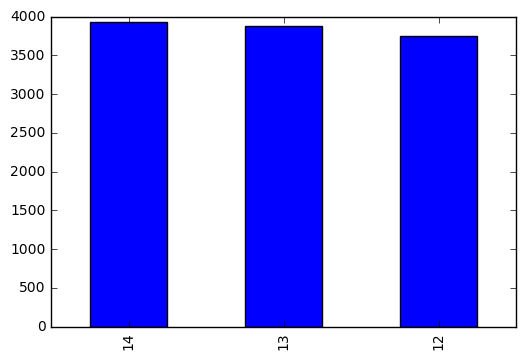

In [23]:
#number of crashes each year
crash_road_data.year.value_counts().plot(kind='bar')

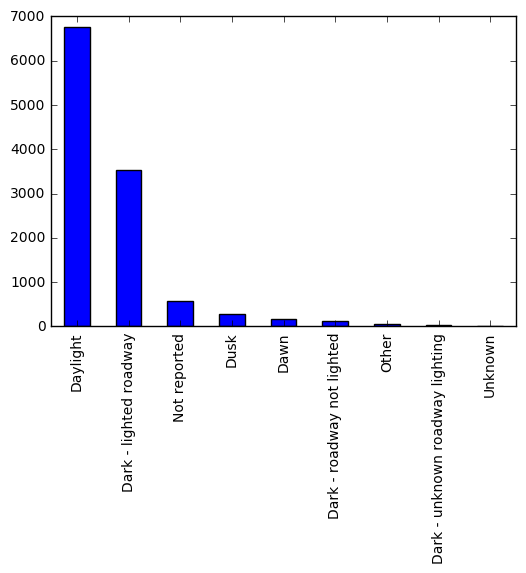

In [24]:
#number of crashes vs ambient light
crash_road_data.ambient_light.value_counts().plot(kind='bar')

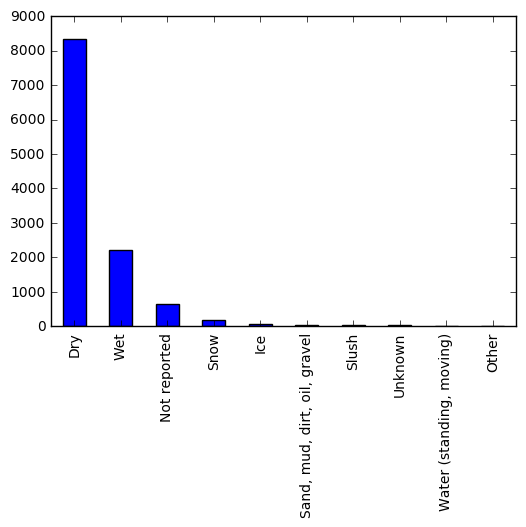

In [25]:
#number of crashes vs ambient light
crash_road_data.road_surface_condition.value_counts().plot(kind='bar')

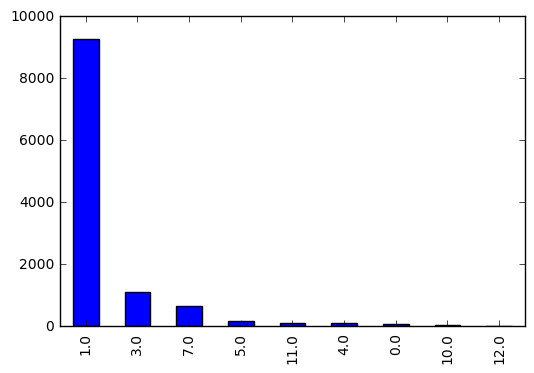

In [27]:
#number of crashes vs facility type
crash_road_data.facility.value_counts().plot(kind='bar')

In [ ]:
# the top 3 dangerous facilities are (1,3,7) i.e (Mainline roadway, Tunnel, Simple Ramp)

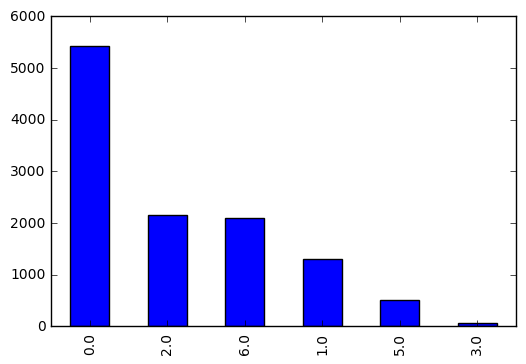

In [28]:
#number of crashes vs median type
crash_road_data.med_type.value_counts().plot(kind='bar')

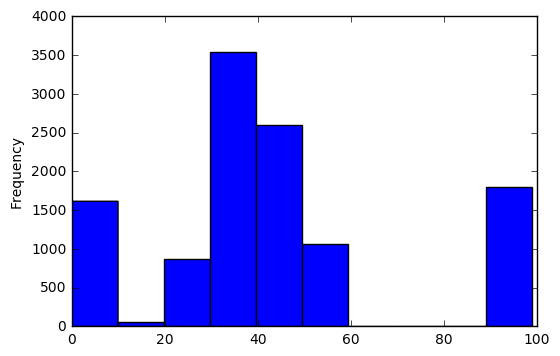

In [26]:
#Histogram of crashes over speed limits
crash_road_data.speed_lim.plot(kind='hist')

Axes(0.125,0.125;0.775x0.775)


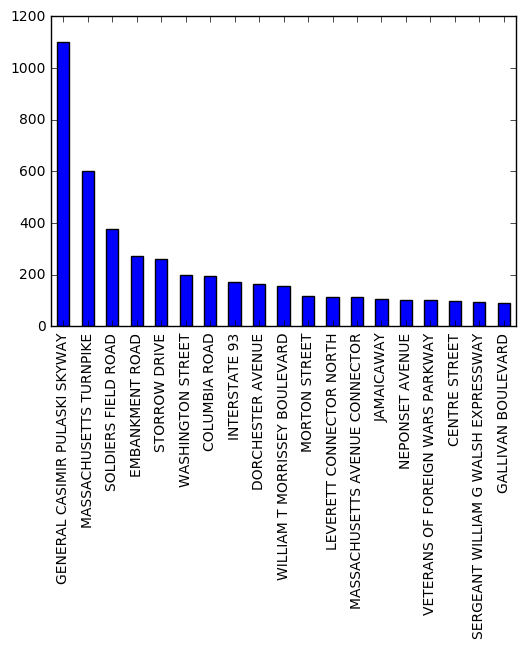

In [11]:
#High crash streets
print crash_road_data.st_name.value_counts().iloc[1:20].plot(kind='bar')

Axes(0.125,0.125;0.775x0.775)


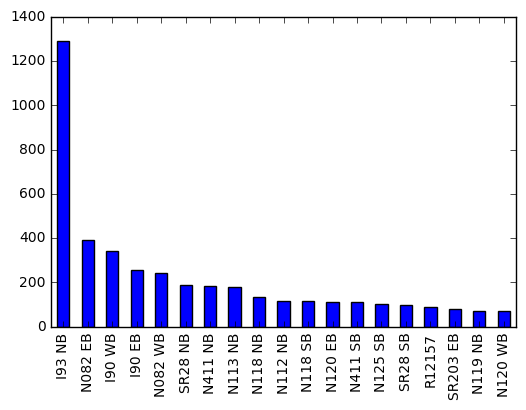

In [12]:
#High crash route ids
print crash_road_data.route_id.value_counts().iloc[1:20].plot(kind='bar')